## Train the first phase of the classification(Normal,pneumonie)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import pandas as pd

In [2]:
# data transform
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = 'Data_1'
image_datasets_1 = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders_1 = {x: torch.utils.data.DataLoader(image_datasets_1[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [4]:
class_names_1 = image_datasets_1['train'].classes
dataset_sizes_1 = {x: len(image_datasets_1[x]) for x in ['train', 'val']}

In [5]:
class_names_1

['Normal', 'pneumonie']

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_acc = []
    valid_acc = []
    train_loss = []
    valid_loss = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders_1[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes_1[phase]
            epoch_acc = running_corrects.double() / dataset_sizes_1[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, train_loss, valid_acc, valid_loss

In [7]:
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
# for param in resnet.parameters():
#     param.requires_grad = False
resnet.fc = nn.Linear(num_ftrs, len(class_names_1))
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Observe that all parameters are being optimized
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
resnet, train_acc, train_loss, valid_acc, valid_loss = train_model(resnet,
                                        criterion, optimizer,exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4809 Acc: 0.8092
val Loss: 0.3687 Acc: 0.8351

Epoch 1/24
----------
train Loss: 0.3671 Acc: 0.8626
val Loss: 0.1153 Acc: 0.9553

Epoch 2/24
----------
train Loss: 0.3196 Acc: 0.8861
val Loss: 0.1246 Acc: 0.9518

Epoch 3/24
----------
train Loss: 0.3185 Acc: 0.8936
val Loss: 0.2947 Acc: 0.8728

Epoch 4/24
----------
train Loss: 0.2672 Acc: 0.9097
val Loss: 0.1189 Acc: 0.9567

Epoch 5/24
----------
train Loss: 0.2422 Acc: 0.9151
val Loss: 0.1223 Acc: 0.9686

Epoch 6/24
----------
train Loss: 0.2730 Acc: 0.9145
val Loss: 0.1663 Acc: 0.9378

Epoch 7/24
----------
train Loss: 0.1799 Acc: 0.9368
val Loss: 0.0989 Acc: 0.9630

Epoch 8/24
----------
train Loss: 0.1814 Acc: 0.9437
val Loss: 0.0862 Acc: 0.9672

Epoch 9/24
----------
train Loss: 0.1835 Acc: 0.9425
val Loss: 0.0824 Acc: 0.9706

Epoch 10/24
----------
train Loss: 0.1628 Acc: 0.9520
val Loss: 0.0812 Acc: 0.9713

Epoch 11/24
----------
train Loss: 0.1673 Acc: 0.9475
val Loss: 0.0793 Acc: 0.9700

Ep

In [8]:
predicted = []
labels = []
for data, label in dataloaders_1["val"]:
    outputs = resnet(data)
    _, preds = torch.max(outputs, 1)
    labels.extend(label.tolist())
    predicted.extend(preds.tolist())
print(len(predicted))
print(len(labels))

1431
1431


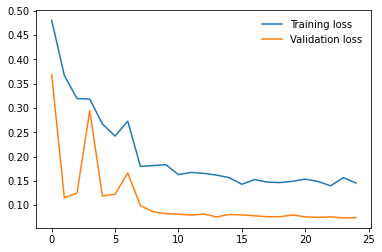

In [9]:
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend(frameon=False)
plt.show()

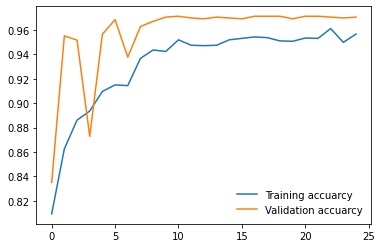

In [10]:
plt.plot(train_acc, label='Training accuarcy')
plt.plot(valid_acc, label='Validation accuarcy')
plt.legend(frameon=False)
plt.show()

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
print(classification_report(labels, predicted, target_names=class_names_1))
cmf = confusion_matrix(labels,predicted,normalize="true")
cmf = pd.DataFrame(cmf, 
  index = class_names_1,
  columns = class_names_1)

              precision    recall  f1-score   support

      Normal       0.95      0.96      0.96       479
   pneumonie       0.98      0.98      0.98       952

    accuracy                           0.97      1431
   macro avg       0.97      0.97      0.97      1431
weighted avg       0.97      0.97      0.97      1431



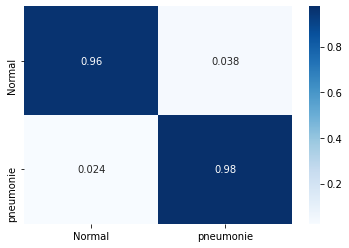

In [12]:
sns.heatmap(cmf, cmap='Blues',annot=True)

## get the feature vector from the covid and non covid

In [13]:
model = resnet
layer = model._modules.get('avgpool')

In [14]:
data_dir = 'Data_2/'
image_datasets_2 = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders_2 = {x: torch.utils.data.DataLoader(image_datasets_2[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [15]:
dataset_sizes_2 = {x: len(image_datasets_2[x]) for x in ['train', 'val']}
class_names_2 = image_datasets_2['train'].classes
class_names_2

['COVID-19', 'non-COVID-19']

In [16]:
def get_vector_from_batch(batch,model):
    my_embeddings = torch.zeros(batch.shape[0],512)
    def copy_data(m, i, o):
        N,C,H,W = o.shape
        o = o.reshape(N,C)
        my_embeddings.copy_(o.data)
    h = layer.register_forward_hook(copy_data)
    model(batch)    # 7. Detach our copy function from the layer
    h.remove()    # 8. Return the feature vector
    #return features
    return my_embeddings

In [17]:
train_data_set = torch.empty(0,513)
for data,label in dataloaders_2["train"]:
    vector_features = get_vector_from_batch(data,model)
    vector_features = torch.cat((vector_features,label.reshape(-1,1).float()),1)
    train_data_set = torch.cat((train_data_set,vector_features),0)

In [18]:
val_data_set = torch.empty(0,513)
for data,label in dataloaders_2["val"]:
    vector_features = get_vector_from_batch(data,model)
    vector_features = torch.cat((vector_features,label.reshape(-1,1).float()),1)
    val_data_set = torch.cat((val_data_set,vector_features),0)

In [19]:
train_df = pd.DataFrame(train_data_set.numpy())
val_df = pd.DataFrame(val_data_set.numpy())
X_train = train_df.loc[:,:511]
y_train = train_df.loc[:,512]
X_val = val_df.loc[:,:511]
y_val = val_df.loc[:,512]

In [20]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,4.780672,3.648827,0.766199,5.032229,5.487140,3.811644,3.286817,3.272629,3.189388,3.878075,...,4.084568,3.626387,2.788576,3.376503,1.416519,4.806436,0.544019,5.702686,3.913139,4.355067
1,0.853404,0.161060,0.168109,0.689483,0.441593,0.116573,1.991347,0.800933,1.274839,0.714169,...,0.701749,0.629379,0.006900,0.906463,0.255667,0.070327,0.000000,1.076966,0.607893,0.688281
2,2.159546,2.217506,1.207219,2.534765,1.859745,1.567364,1.178215,2.356596,1.326023,1.075339,...,1.752168,0.971145,0.692433,1.664463,0.160089,2.262599,0.083026,2.328383,1.150683,1.564910
3,1.003140,0.611247,0.124396,1.876861,1.729450,0.282985,2.631355,1.800438,0.532838,1.051250,...,0.468186,0.524298,0.239074,0.550960,1.334177,0.683950,1.088635,0.663046,1.394752,0.738687
4,1.628822,1.539545,2.542193,3.410957,2.300210,0.895418,2.217288,4.589044,3.972516,2.765754,...,2.957246,4.997468,2.201696,1.275211,1.438118,2.952421,1.400079,2.917141,2.533498,3.603861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2257,4.885199,2.892106,1.649741,3.510874,4.573176,2.579103,2.702294,3.063379,1.789661,4.886083,...,2.039655,3.390663,3.192866,3.114160,0.179208,2.318156,0.726264,6.218150,2.811490,5.154008
2258,0.900498,1.675610,1.884970,3.517445,1.565255,2.311597,1.392469,4.151293,5.153139,2.375042,...,2.951900,6.273269,2.535354,2.803545,1.050878,3.878041,0.750559,2.950715,3.905910,3.489128
2259,5.051883,3.055994,1.617155,5.262040,3.061043,4.976571,0.726404,2.479157,4.114794,2.317750,...,3.595714,1.812973,2.886306,2.840864,0.782223,4.814335,1.288286,5.428624,4.339649,4.427824
2260,0.893385,2.056482,1.415062,2.869106,2.366255,1.346371,1.531290,2.029397,2.838483,1.916554,...,2.679295,1.921116,2.035328,1.944098,1.071676,1.176629,0.842105,2.320950,2.065818,2.432477


In [21]:
X_val

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.942442,0.947502,1.330131,1.114431,0.776182,0.546258,1.297881,1.744943,1.147026,1.201077,...,1.131818,0.284336,1.488895,0.695822,0.509032,1.183261,0.618434,1.257652,1.487998,1.191847
1,2.949499,2.139144,0.751667,0.947313,2.081467,1.447880,1.697419,2.295204,0.789203,1.771376,...,2.570296,1.064444,1.433402,1.829358,1.285768,1.555056,2.388938,1.424089,1.737478,1.856259
2,0.466336,0.464040,1.017554,0.086129,0.118800,1.005832,0.571776,0.226659,3.109828,0.408835,...,0.401195,0.044552,1.192929,0.312489,0.963584,1.445401,0.746291,0.035823,1.937102,0.025458
3,6.319531,3.569089,1.649967,5.518997,4.688981,2.481984,3.476136,6.428491,2.726479,5.398639,...,4.060734,4.297673,2.987932,2.687440,0.972488,5.053382,2.019446,6.620450,4.687328,4.433015
4,1.845835,0.685878,0.719621,1.284427,0.281790,1.307407,3.869298,0.490730,3.755241,1.914269,...,0.605509,3.058104,1.318699,1.063390,1.425344,2.516992,0.000000,1.449827,1.861203,2.402375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,0.034169,0.150500,0.848417,0.298284,0.185024,0.065810,0.000000,0.592135,0.800331,0.011534,...,0.757460,0.179208,0.396234,0.578252,1.768168,0.625454,0.859062,0.119589,0.364769,0.026186
948,2.949778,1.294598,2.176640,1.611333,1.516620,1.351271,2.010842,2.802786,1.103980,2.832929,...,2.070964,1.941517,2.633971,2.483387,0.956617,3.104342,0.886564,2.940046,3.423226,2.670691
949,4.535501,5.036533,2.453823,4.417117,3.671421,3.924851,2.959502,4.276402,4.501682,4.087489,...,4.092863,4.943571,4.553597,3.730054,2.846315,3.871705,0.246764,4.074544,6.426731,5.153198
950,0.106273,0.360384,0.961646,0.000000,0.134050,0.449361,0.638935,0.072263,0.316925,0.253705,...,0.444757,0.252927,0.190200,0.177883,0.165404,0.681331,0.087729,0.383511,0.456990,0.000000


In [22]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [23]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10]}
clf_grid = GridSearchCV(svm.SVC(), param_grid, verbose=1)
clf_grid.fit(X_train, y_train)
print("Best Parameters:\n", clf_grid.best_params_)
print("Best Estimators:\n", clf_grid.best_estimator_)
print("Best score:\n", clf_grid.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  3.7min finished


Best Parameters:
 {'C': 100, 'gamma': 0.001}
Best Estimators:
 SVC(C=100, gamma=0.001)
Best score:
 0.9456230830842565


In [24]:
clf = svm.SVC(C=100, gamma=0.001)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)


In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
print(classification_report(y_val, y_pred, target_names=class_names_2))

              precision    recall  f1-score   support

    COVID-19       0.76      0.81      0.78       112
non-COVID-19       0.97      0.97      0.97       840

    accuracy                           0.95       952
   macro avg       0.87      0.89      0.88       952
weighted avg       0.95      0.95      0.95       952



In [26]:
cmf = confusion_matrix(y_val,y_pred,normalize="true")
print(cmf)
cmf = pd.DataFrame(cmf, 
  index = class_names_2,
  columns = class_names_2)

[[0.8125     0.1875    ]
 [0.03452381 0.96547619]]


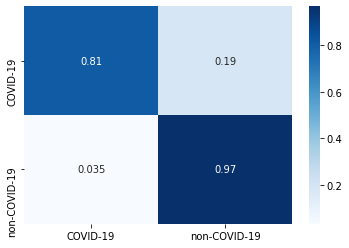

In [27]:
sns.heatmap(cmf, cmap='Blues',annot=True)

## logistic regression

In [28]:
lrclf = LogisticRegression(max_iter=10000)
lrclf.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

[[0.74107143 0.25892857]
 [0.03214286 0.96785714]]


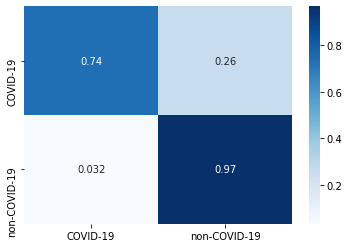

In [29]:
y_pred = lrclf.predict(X_val)
cmf = confusion_matrix(y_val,y_pred,normalize="true")
print(cmf)
cmf = pd.DataFrame(cmf, 
  index = class_names_2,
  columns = class_names_2)
sns.heatmap(cmf, cmap='Blues',annot=True)

## decission tree

In [30]:
from sklearn.tree import DecisionTreeClassifier
Dtclf = DecisionTreeClassifier(criterion="entropy", max_depth=220)
Dtclf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=220)

[[0.54464286 0.45535714]
 [0.07857143 0.92142857]]


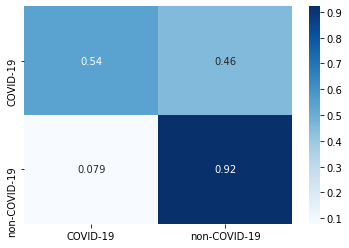

In [31]:
y_pred = Dtclf.predict(X_val)
cmf = confusion_matrix(y_val,y_pred,normalize="true")
print(cmf)
cmf = pd.DataFrame(cmf, 
  index = class_names_2,
  columns = class_names_2)
sns.heatmap(cmf, cmap='Blues',annot=True)

## FNN

In [147]:
from torch.utils.data import TensorDataset, DataLoader
train_data = TensorDataset(torch.from_numpy(X_train.to_numpy()),torch.from_numpy(y_train.to_numpy()))
valid_data = TensorDataset(torch.from_numpy(X_val.to_numpy()),torch.from_numpy(y_val.to_numpy()))
train_loader = DataLoader(train_data,shuffle=True,batch_size=4)
val_loader = DataLoader(valid_data,shuffle=True,batch_size=4)

In [148]:
x,y = next(iter(train_loader))

In [149]:
x.shape

torch.Size([4, 512])

In [150]:
y.shape

torch.Size([4])

In [151]:
class fnn_model(nn.Module):
    def __init__(self):
        super(fnn_model,self).__init__()
        
        self.fc1 = nn.Linear(in_features=512,out_features=256)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5 ,inplace=False)
        self.fc2 = nn.Linear(in_features = 256,out_features=128)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(p=0.5,inplace=False)
        self.out = nn.Linear(in_features=128,out_features=2)
    def forward(self,inp):
        x = self.fc1(inp)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.out(x)
        return x


In [152]:
fnn = fnn_model()

In [153]:
fnn

fnn_model(
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU(inplace=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=128, out_features=2, bias=True)
)

In [154]:
dataloaders_3 = {"train":train_loader,"val":val_loader}
dataset_sizes_3 = dataset_sizes_2

In [155]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_acc = []
    valid_acc = []
    train_loss = []
    valid_loss = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders_3[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.type(torch.LongTensor))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes_3[phase]
            epoch_acc = running_corrects.double() / dataset_sizes_3[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, train_loss, valid_acc, valid_loss

In [156]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Observe that all parameters are being optimized
optimizer = optim.SGD(fnn.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
fnn, train_acc, train_loss, valid_acc, valid_loss = train_model(fnn,
                                        criterion, optimizer,exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.5051 Acc: 0.8683
val Loss: 0.3938 Acc: 0.8824

Epoch 1/29
----------
train Loss: 0.4233 Acc: 0.8846
val Loss: 0.3300 Acc: 0.8834

Epoch 2/29
----------
train Loss: 0.3633 Acc: 0.8912
val Loss: 0.2736 Acc: 0.8897

Epoch 3/29
----------
train Loss: 0.3146 Acc: 0.8952
val Loss: 0.2519 Acc: 0.9034

Epoch 4/29
----------
train Loss: 0.2856 Acc: 0.9014
val Loss: 0.2213 Acc: 0.9076

Epoch 5/29
----------
train Loss: 0.2707 Acc: 0.8996
val Loss: 0.2093 Acc: 0.9065

Epoch 6/29
----------
train Loss: 0.2606 Acc: 0.9019
val Loss: 0.2065 Acc: 0.9065

Epoch 7/29
----------
train Loss: 0.2597 Acc: 0.9023
val Loss: 0.2059 Acc: 0.9118

Epoch 8/29
----------
train Loss: 0.2512 Acc: 0.9036
val Loss: 0.2026 Acc: 0.9097

Epoch 9/29
----------
train Loss: 0.2469 Acc: 0.9050
val Loss: 0.2007 Acc: 0.9118

Epoch 10/29
----------
train Loss: 0.2520 Acc: 0.9107
val Loss: 0.2006 Acc: 0.9118

Epoch 11/29
----------
train Loss: 0.2574 Acc: 0.9041
val Loss: 0.2005 Acc: 0.9118

Ep

In [157]:
predicted = []
labels = []
for data, label in dataloaders_3["val"]:
    outputs = fnn(data)
    _, preds = torch.max(outputs, 1)
    labels.extend(label.tolist())
    predicted.extend(preds.tolist())
print(len(predicted))
print(len(labels))

952
952


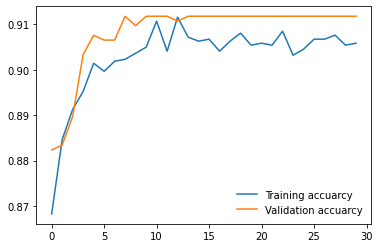

In [158]:
plt.plot(train_acc, label='Training accuarcy')
plt.plot(valid_acc, label='Validation accuarcy')
plt.legend(frameon=False)
plt.show()

In [159]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
print(classification_report(labels, predicted, target_names=class_names_2))
cmf = confusion_matrix(labels,predicted,normalize="true")
cmf = pd.DataFrame(cmf, 
  index = class_names_2,
  columns = class_names_2)

              precision    recall  f1-score   support

    COVID-19       0.71      0.42      0.53       112
non-COVID-19       0.93      0.98      0.95       840

    accuracy                           0.91       952
   macro avg       0.82      0.70      0.74       952
weighted avg       0.90      0.91      0.90       952



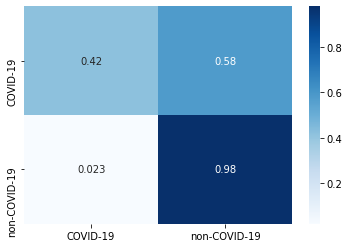

In [160]:
sns.heatmap(cmf, cmap='Blues',annot=True)

## combine the two models (CNN+SVM)

In [169]:
data_dir = 'Data_val/'
image_datasets_val = datasets.ImageFolder(data_dir,data_transforms["val"])
dataloaders_val = torch.utils.data.DataLoader(image_datasets_val, batch_size=1,shuffle=True, num_workers=4)


In [170]:
val_classes = image_datasets_val.classes
val_classes

['COVID-19', 'Normal', 'non-COVID-19']

## explain evry single step for one image example 

In [171]:
image,label = next(iter(dataloaders_val))

In [184]:
outputs = resnet(image)
image_feature_vector = get_vector_from_batch(image,resnet)
_, preds = torch.max(outputs, 1)

In [185]:
class_names_1[preds.item()]

'pneumonie'

In [188]:
image_feature_vector = pd.DataFrame(image_feature_vector.numpy())

In [187]:
type(X_val)

pandas.core.frame.DataFrame

In [189]:
type(image_feature_vector)

pandas.core.frame.DataFrame

In [191]:
image_feature_vector.shape

(1, 512)

In [196]:
class_names_2 [int(clf.predict(image_feature_vector)[0])]

'non-COVID-19'

In [199]:
val_classes[label.item()]

'non-COVID-19'

## for all the validation data

In [200]:
predicted = []
labels = []
for image,label in dataloaders_val:
    outputs = resnet(image)
    image_feature_vector = get_vector_from_batch(image,resnet)
    _, preds = torch.max(outputs, 1)
    if class_names_1[preds.item()] == 'pneumonie':
        image_feature_vector = pd.DataFrame(image_feature_vector.numpy())
        if class_names_2 [int(clf.predict(image_feature_vector)[0])] == 'non-COVID-19':
            predicted.append(2)
        else:
            predicted.append(0)
    
    else:
        predicted.append(1)
    labels.append(label.item())

In [201]:
print(len(predicted))
print(len(labels))

1431
1431


In [203]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
print(classification_report(labels, predicted, target_names=val_classes))
cmf = confusion_matrix(labels,predicted,normalize="true")
cmf = pd.DataFrame(cmf, 
  index = val_classes,
  columns = val_classes)

              precision    recall  f1-score   support

    COVID-19       0.75      0.79      0.77       112
      Normal       0.95      0.96      0.96       479
non-COVID-19       0.95      0.94      0.95       840

    accuracy                           0.94      1431
   macro avg       0.89      0.90      0.89      1431
weighted avg       0.94      0.94      0.94      1431



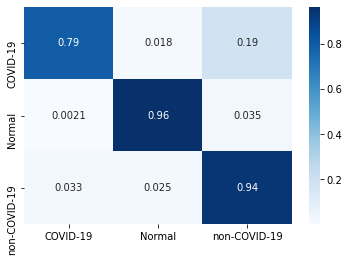

In [204]:
sns.heatmap(cmf, cmap='Blues',annot=True)

## save the 2 models to replicate the results

In [206]:
from joblib import dump, load
dump(clf, 'SVM_covid_noncovid.joblib') 

['SVM_covid_noncovid.joblib']

In [207]:
torch.save(resnet,"resnet_normal_pneumonie")